In [1]:
import importlib
import numpy as np
import pipeline
from importlib import reload

reload(pipeline)

<module 'pipeline' from 'C:\\Users\\einkina\\Documents\\School\\Manifold Learning\\manifold-learning\\pipeline.py'>

In [2]:
reload(pipeline)
control_vars = pipeline.get_control_vars(pipeline.get_p())
response_matrix = pipeline.generate_array_of_swiss_rolls(control_vars)
standardized_x, centered_y, edges, y_means, y_scaler, x_means, x_stds = pipeline.prepare_data(control_vars, response_matrix)

In [3]:
reload(pipeline)
q = pipeline.solve_semidefinite_programming(standardized_x, centered_y, edges)

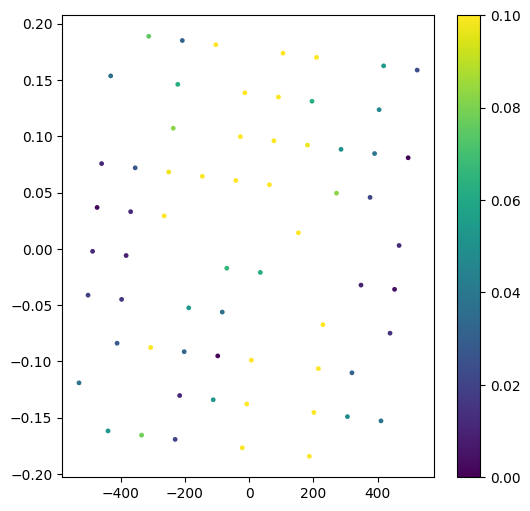

0.04925226683437373


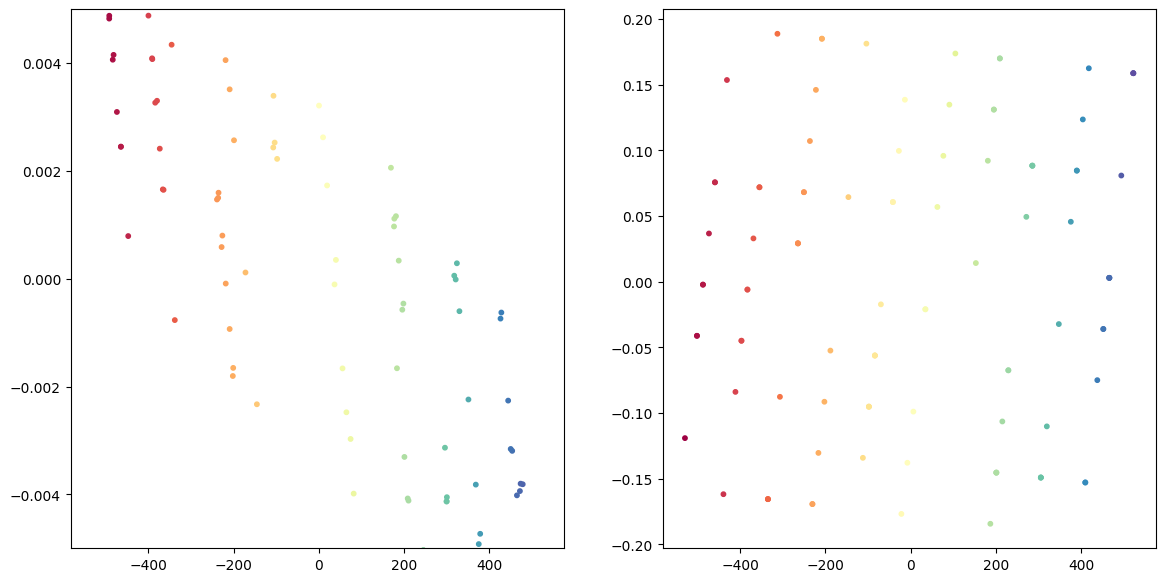

In [39]:
reload(pipeline)
ld_embedding = pipeline.reduce_dimensions(q)
regression_matrix = pipeline.regress(ld_embedding, standardized_x)
reconstructed_y = np.dot(standardized_x, regression_matrix)

rre = pipeline.compute_rre(ld_embedding, reconstructed_y)
pipeline.plot_rre_heatmap(rre, reconstructed_y)
print(np.median(rre))
pipeline.plot_two_embeddings(ld_embedding, reconstructed_y)

In [26]:
reload(pipeline)
test_control_vars = pipeline.get_control_vars(pipeline.get_p())
test_rolls = pipeline.generate_array_of_swiss_rolls(test_control_vars, 10)
for (roll, control_var) in zip(test_rolls, test_control_vars):
    x_opt, x_err = pipeline.predictive_optimization(roll, centered_y, ld_embedding, regression_matrix, y_means, y_scaler)
    x_opt = x_opt * x_stds + x_means
    print("-----------")
    print(f"x_opt  = {x_opt}, x_err = {x_err}")
    print(f"x_real = {control_var}")

-----------
x_opt  = [1.21235898 9.7370773 ], x_err = 3.1619277753687206e-12
x_real = [1, 9]
-----------
x_opt  = [8.00084514 6.37089343], x_err = 1.1911806108993127e-11
x_real = [5, 6]
-----------
x_opt  = [ 0.38512496 10.62513296], x_err = 1.3772295009103857e-11
x_real = [8, 9]
-----------
x_opt  = [ 8.63863268 -0.09727474], x_err = 5.415492525656588e-13
x_real = [8, 1]
-----------
x_opt  = [3.96114093 3.93405358], x_err = 4.555527865117861e-12
x_real = [1, 4]
-----------
x_opt  = [2.03071688 0.78055359], x_err = 1.138938785367208e-11
x_real = [1, 1]
-----------
x_opt  = [2.30440322 6.06051356], x_err = 1.0061821418225878e-11
x_real = [7, 5]
-----------
x_opt  = [10.3348837   4.38631965], x_err = 1.3523123197828149e-11
x_real = [9, 6]
-----------
x_opt  = [1.15248557 5.30515331], x_err = 4.1345578792621334e-12
x_real = [10, 4]
-----------
x_opt  = [9.71139507 7.22590888], x_err = 3.893538989625494e-12
x_real = [6, 9]
